# EDA For batch processing

In [159]:
import os
import re
import pickle
import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, vstack

%matplotlib inline

# Custom modules
import const
import func

## Load data

In [2]:
const.TRAIN_FILES

['train_numeric', 'train_categorical_to_num', 'train_date']

In [152]:
lut = pd.read_csv(const.LOOK_UP_TABLE)
lut.head(3)

,line,station,feature_nr,feat_nr_dat,name_dat,name_cat,name_num,col_dat,col_num,col_cat,station_V2
0,0,0,0,1.0,L0_S0_D1,NaN,L0_S0_F0,0.0,0.0,NaN,0.0
1,0,0,2,3.0,L0_S0_D3,NaN,L0_S0_F2,1.0,1.0,NaN,0.0
2,0,0,4,5.0,L0_S0_D5,NaN,L0_S0_F4,2.0,2.0,NaN,0.0


In [178]:
date_tr = func.load_data_file(const.TRAIN_FILES[2])
date_te = func.load_data_file(const.TEST_FILES[2])

R = date_tr['data']['y']

id_tr = date_tr['data']['ids']
id_te = date_te['data']['ids']

date_tr = date_tr['data']['features']
date_te = date_te['data']['features']

ntrain = date_tr.shape[0]

data = vstack([date_tr, date_te], format='csr')

Returning <open file '/Volumes/My Book/kaggle_bosch/train_date.pkl', mode 'rb' at 0x11bd30db0>.pkl
Returning <open file '/Volumes/My Book/kaggle_bosch/test_date.pkl', mode 'rb' at 0x11bd30db0>.pkl


In [327]:
R.head()

,Response
Id,
4,0
6,0
7,0
9,0
11,0


## Extract data needed for batch analysis

In [463]:
dft = pd.DataFrame({'t_min': data.data[data.indptr[:-1]], 
                    'f_min': data.indices[data.indptr[:-1]],
                    't_max': data.max(1).todense().A1,
                    't_st29': data[:, 883].todense().A1,
                    'Id': pd.concat([id_tr.Id, id_te.Id], axis=0).values})

In [464]:
dft['t_delta'] = dft['t_max'] - dft['t_min']
dft['t_max_r'] = (dft['t_max']*10).round(0).astype(float)/10
dft['t_st29_r'] = (dft['t_st29']*10).round(0).astype(float)/10
dft = dft.merge(R, left_on='Id', right_index=True, how='left')

In [465]:
dft.head()

,Id,f_min,t_max,t_min,t_st29,t_delta,t_max_r,t_st29_r,Response
0,4,0,87.290001,82.239998,87.260002,5.050003,87.3,87.3,0.0
1,6,89,1315.750000,1313.119995,1315.729980,2.630005,1315.8,1315.7,0.0
2,7,0,1624.420044,1618.699951,1624.400024,5.720093,1624.4,1624.4,0.0
3,9,0,1154.160034,1149.199951,1154.119995,4.960083,1154.2,1154.1,0.0
4,11,0,606.020020,602.640015,606.000000,3.380005,606.0,606.0,0.0


(0, 400)

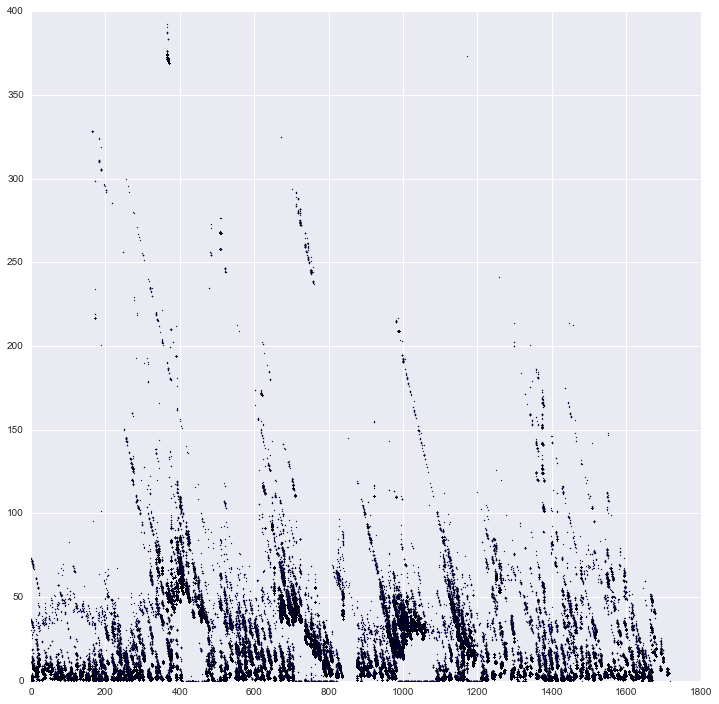

In [466]:
plt.figure(figsize=(12,12))
plt.scatter(x=dft.t_min, y=dft.t_delta, s=1)
plt.xlim([0,1800])
plt.ylim([0,400])

In [467]:
dft.f_min.value_counts().iloc[:6]

0      1349034
89      483190
380     260997
472     110149
288      53669
184      46244
Name: f_min, dtype: int64

## Analysis

In [468]:
def max_diff(x):
    return x.sort_values().diff().max()

In [469]:
dft.head()

,Id,f_min,t_max,t_min,t_st29,t_delta,t_max_r,t_st29_r,Response
0,4,0,87.290001,82.239998,87.260002,5.050003,87.3,87.3,0.0
1,6,89,1315.750000,1313.119995,1315.729980,2.630005,1315.8,1315.7,0.0
2,7,0,1624.420044,1618.699951,1624.400024,5.720093,1624.4,1624.4,0.0
3,9,0,1154.160034,1149.199951,1154.119995,4.960083,1154.2,1154.1,0.0
4,11,0,606.020020,602.640015,606.000000,3.380005,606.0,606.0,0.0


In [470]:
batch_col = 't_st29_r' # 't_max_r'

dft_agg = dft.groupby(batch_col)['t_delta','f_min','Response'].agg({'t_delta':['min',
                                                                    'max',
                                                                    lambda x: x.max()-x.min(),
                                                                    'count',max_diff],
                                              'f_min': ['first'],
                                              'Response':'sum'})

dft_agg.columns = ['min','max','range','count','max_diff','count_defects','first_feature']
dft_agg['batch_no'] = range(dft_agg.shape[0])

In [471]:
dft_agg.head(3)

,min,max,range,count,max_diff,count_defects,first_feature,batch_no
t_st29_r,,,,,,,,
0.0,-1710.619995,373.26001,2083.879883,128429,72.629974,333.0,0,0
0.4,0.050000,0.82000,0.770000,138,0.570000,2.0,883,1
0.5,0.030000,0.76000,0.730000,220,0.310000,1.0,883,2


845


(0, 400)

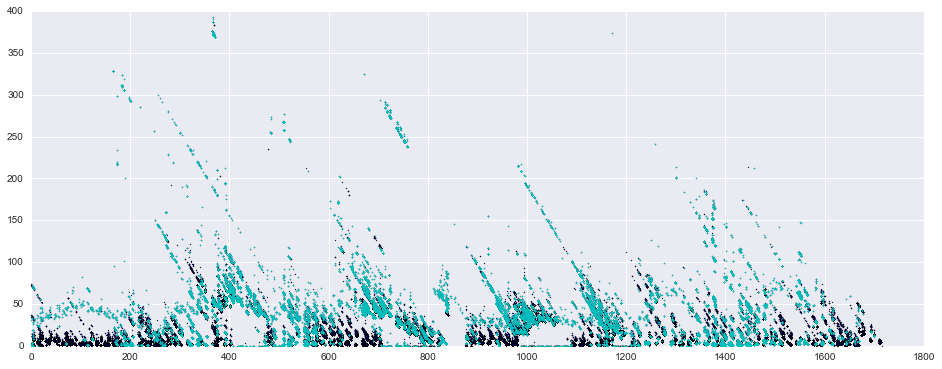

In [472]:
filter_batch = (dft_agg['range']>40) & (dft_agg['count']>300) #& (dft_agg['first_feature']==472)# & (dft_agg['max_diff']<100)
print filter_batch.sum()
plt.figure(figsize=(16,6))
plt.scatter(x=dft.t_min, y=dft.t_delta, s=1)

for ix in dft_agg[filter_batch].index:
    #ix = dft_agg.sort_values('range', ascending=False).iloc[n,:].name
    
    plt.scatter(x=dft[dft[batch_col]==ix].t_min, y=dft[dft[batch_col]==ix].t_delta, s=5, color='c', marker='.')

plt.xlim([0,1800])
plt.ylim([0,400])

#plt.xlim([900,1100])
#plt.ylim([0,100])

#dft['batch_ind']


In [473]:
dft['in_batch'] = dft[batch_col].isin(dft_agg[filter_batch].index).astype(int)
dft = dft.merge(dft_agg[['batch_no']], left_on=batch_col, right_index=True, how='left')
dft.loc[dft['in_batch']==0,'batch_no'] = 0
dft.groupby('in_batch').mean()

,Id,f_min,t_max,t_min,t_st29,t_delta,t_max_r,t_st29_r,Response,batch_no
in_batch,,,,,,,,,,
0,1.183778e+06,100.407769,838.310486,829.001892,838.031921,9.308544,838.310093,838.031908,0.005550,0.000000
1,1.183617e+06,149.189515,948.245728,933.699402,654.333984,14.546355,948.245043,654.333878,0.006955,2996.447382


In [474]:
dft.head(5)

,Id,f_min,t_max,t_min,t_st29,t_delta,t_max_r,t_st29_r,Response,in_batch,batch_no
0,4,0,87.290001,82.239998,87.260002,5.050003,87.3,87.3,0.0,0,0
1,6,89,1315.750000,1313.119995,1315.729980,2.630005,1315.8,1315.7,0.0,0,0
2,7,0,1624.420044,1618.699951,1624.400024,5.720093,1624.4,1624.4,0.0,0,0
3,9,0,1154.160034,1149.199951,1154.119995,4.960083,1154.2,1154.1,0.0,0,0
4,11,0,606.020020,602.640015,606.000000,3.380005,606.0,606.0,0.0,0,0


In [475]:
dft['batch_no'].nunique()

845

In [478]:
batch_info = dft.groupby('batch_no').Response.agg({'mean', 'count', 'sum'})
batch_info.columns = ['Sample_count','Defect_count','Error_rate']
batch_info.head()

,Sample_count,Defect_count,Error_rate
batch_no,,,
0,1027728,5681.0,0.005528
327,203,0.0,0.000000
523,157,0.0,0.000000
751,184,3.0,0.016304
826,222,0.0,0.000000


## Export data

In [479]:
batch_info.to_csv(os.path.join(const.DATA_PATH, 'feature_set_batch_info.csv'), 
                  index_label='batch_number')

In [480]:
dft[['Id','batch_no']].to_csv(os.path.join(const.DATA_PATH, 'feature_set_batch.csv'), 
                              index_label='batch_number')